In [1]:
"""
*Filename: DeepNetTrainer
*Description: The original Deep Sets Trainer file which uses the standard DeepSets architecture and 
the base track and jet features to regress the bhadron features
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""

'\n*Filename: DeepNetTrainer\n*Description: The original Deep Sets Trainer file which uses the standard DeepSets architecture and \nthe base track and jet features to regress the bhadron features\nDate: 16/02/2023\nAuthor: Kaylen Smith Darnbrook\n'

In [2]:
#Starts by importing the relevant python modules
import os
import numpy as np
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import PredictOnEpoch
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
%matplotlib inline

2023-02-16 13:08:58.052676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 13:08:58.228898: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-16 13:08:58.233026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-16 13:08:58.233042: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [3]:
#Format the style and format of the matplotlib plots
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'red'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [4]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [5]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 128 # This is the batch size of the mini batches used during training
EPOCHS = 100 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [6]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores")
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [7]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]

In [8]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [9]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [10]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [11]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [12]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's ppredictions

There are 3 outputs
There are 32 inputs


In [13]:
#Load in the b_jet information
jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi], axis = -1)

In [14]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [15]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:108: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [16]:
#Standardize the track inputs
Scaler = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1,Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape= (Num_events,Num_tracks,Num_features))

In [17]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads, train_size=0.8, random_state=42)

In [18]:
#Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate = 1e-4,
maximal_learning_rate = 1e-3,
scale_fn = lambda x: 1/(2**(x-1)),
step_size = 2.0 * steps_per_epoch
)
        
# Builds the deep neural network
track_layers = [32,32,32,32]
jet_layers = [64,64,64,64]
b_jets_layers = [64,64,64,64]

len1 = [len(track_features)]+track_layers
print(len1)

#Initializers the optimizer used for training the network
optimizer=tf.keras.optimizers.Nadam(LR,beta_1=0.9, beta_2 = 0.999, clipnorm = 1.0, epsilon= 1e-8, ema_momentum=True)
optimizer_Constant = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9, clipnorm = 1.0, nesterov = True )

#Builds the DeepSet Neural Network
DeepNet = DSNNA.DeepSetNeuralNetwork(
    [len(track_features)] + track_layers, jet_layers,np.shape(y_train)[1],optimizer)

DeepNet.compile(
    loss = DSNNA.LogNormal_Loss_Function,
    optimizer = optimizer,
)

[8, 32, 32, 32, 32]


2023-02-16 13:10:50.844507: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 13:10:50.844542: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 13:10:50.844562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-02-16 13:10:50.846719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
#Summarises the Deep Set Neural Network Architecture
print(DeepNet.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 32)         288       
 tributed)                                                       
                                                             

In [20]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=60,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-8)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&BiasesLogNormal.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


In [21]:
# Train the neural network using LogNormal
history = DeepNet.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = BATCHSIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping,reduce_learn_on_plateau,PredictOnEpoch(DeepNet,X_train,y_train,"DeepNetMSE1"),cp_callback]
)

Epoch 1/100
426/426 [==============================] - 18s 25ms/step - loss: 1074151620608.0000 - val_loss: 2331481088.0000 - lr: 1.0000e-04
Epoch 2/100
426/426 [==============================] - 9s 22ms/step - loss: 7232348160.0000 - val_loss: 2834882625536.0000 - lr: 1.0000e-04
Epoch 3/100
426/426 [==============================] - 10s 23ms/step - loss: 2748600576.0000 - val_loss: 19659235328.0000 - lr: 1.0000e-04
Epoch 4/100
426/426 [==============================] - 10s 24ms/step - loss: 981044288.0000 - val_loss: 14915790848.0000 - lr: 1.0000e-04
Epoch 5/100
426/426 [==============================] - 10s 23ms/step - loss: 231701344.0000 - val_loss: 134366368.0000 - lr: 1.0000e-04
Epoch 6/100
426/426 [==============================] - 9s 22ms/step - loss: 38401704.0000 - val_loss: 255074512.0000 - lr: 1.0000e-04
Epoch 7/100
426/426 [==============================] - 9s 22ms/step - loss: 4090789.5000 - val_loss: 100030784.0000 - lr: 1.0000e-04
Epoch 8/100
426/426 [==================

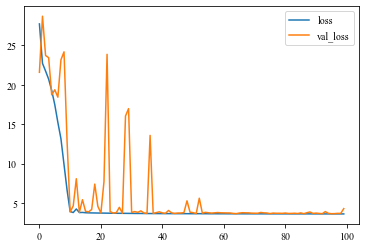

In [22]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/Results/history.csv')

In [23]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

Minimum validation loss: 37.74677658081055


In [24]:
#Import the arrays storing the predicted momenta and asscoiated uncertainties
# of the bhadrons made per epoch
from DeepSetNeuralNetArchitecture import Predicted_Bhad_px
from DeepSetNeuralNetArchitecture import Predicted_Bhad_px_uncertainties
print(Predicted_Bhad_px.shape)
print(Predicted_Bhad_px_uncertainties.shape)
Predicted_Bhad_px = Predicted_Bhad_px.reshape(-1,y_train.shape[0])
Predicted_Bhad_px_uncertainties = Predicted_Bhad_px_uncertainties.reshape(-1,y_train.shape[0])
print(Predicted_Bhad_px.shape)
print(Predicted_Bhad_px_uncertainties.shape)

(5396886,)
(5396886,)
(99, 54514)
(99, 54514)


In [25]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(X_train,y_train,verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

1704/1704 - 2s - loss: 97.4408 - 2s/epoch - 1ms/step
The Loaded DeepNet has loss:  97.4408187866211


In [26]:
#Calculate the metrics to study how the neural network evolved over time.
Mean_Predictions = np.mean(Predicted_Bhad_px,axis = 1)
Std_Predictions = np.std(Predicted_Bhad_px, axis = 1)

Mean_Predictions_Uncertainities = np.mean(Predicted_Bhad_px_uncertainties, axis = 1)
Std_Predictions_Uncertainties = np.std(Predicted_Bhad_px_uncertainties, axis = 1)

PredDiff = np.mean(Predicted_Bhad_px - y_train[:,0])
PredDiffUncertainty = np.std(Predicted_Bhad_px - y_train[:,0])

Scaled_Mean_Squared_Error = (Mean_Predictions - np.mean(y_train[:,0], axis = 0))/(Std_Predictions_Uncertainties)

True_X_Momentum = np.full(np.shape(Mean_Predictions),fill_value = np.mean(y_train[:,0]))
Std_X_Momentum =np.full(np.shape(Mean_Predictions),fill_value = np.std(y_train[:,0])) 
print(True_X_Momentum.shape)

(99,)


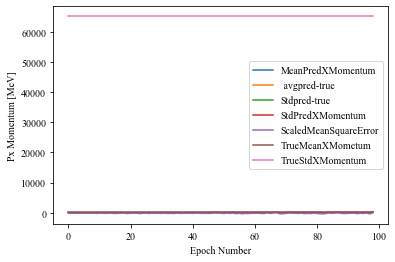

In [66]:
#Plot how the metrics above change over time.
Figure, axes = plt.subplots()
axes.set_xlabel("Epoch Number")
axes.set_ylabel("Px Momentum [MeV]")
pred = axes.plot(Mean_Predictions, label  = "MeanPredXMomentum")
Differences = axes.plot(PredDiff, label = " avgpred-true")
DifferencesUncertainties = axes.plot(PredDiffUncertainty, label = "Stdpred-true")
StdPred = axes.plot(Std_Predictions, label = "StdPredXMomentum")
SMSE = axes.plot(Scaled_Mean_Squared_Error, label = "ScaledMeanSquareError")
TXM = axes.plot(True_X_Momentum, label = "TrueMeanXMometum")
STXM = axes.plot(Std_X_Momentum, label = "TrueStdXMomentum")
axes.legend()

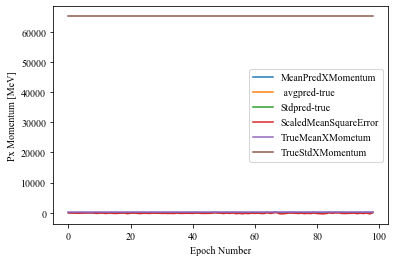

In [65]:
Figure, axes = plt.subplots()
axes.set_xlabel("Epoch Number")
axes.set_ylabel("Px Momentum [MeV]")
pred = axes.plot(Mean_Predictions, label  = "MeanPredXMomentum")
Differences = axes.plot(PredDiff, label = " avgpred-true")
DifferencesUncertainties = axes.plot(PredDiffUncertainty, label = "Stdpred-true")
SMSE = axes.plot(Scaled_Mean_Squared_Error, label = "ScaledMeanSquareError")
TXM = axes.plot(True_X_Momentum, label = "TrueMeanXMometum")
STXM = axes.plot(Std_X_Momentum, label = "TrueStdXMomentum")
axes.legend()

In [29]:
#Output predictions of trained neural network
Predictions = DeepNet.predict(X_train)
print(Predictions.shape)

1704/1704 [==============================] - 2s 1ms/step
(54514, 6)


In [ ]:
#Below calculates the resolutions, resolutions scaled by 
#standard deviation of bhads.

In [30]:
Error_px = y_train[:,0] - Predictions[:,0]
Pull_bhads_px = Error_px/np.std(bhads[:,0])
Pull_px = Error_px/Predictions[:,3]

In [31]:
Error_py = y_train[:,1] - Predictions[:,1]
Pull_bhads_py = Error_py/np.std(bhads[:,1])
Pull_py = Error_py/Predictions[:,4]

In [32]:
Error_pz = y_train[:,2] - Predictions[:,2]
Pull_bhads_pz = Error_pz/np.std(bhads[:,2])
Pull_pz = Error_pz/Predictions[:,5]

In [ ]:
#Plot the results:

1.1826752324418532
65127.29345682056


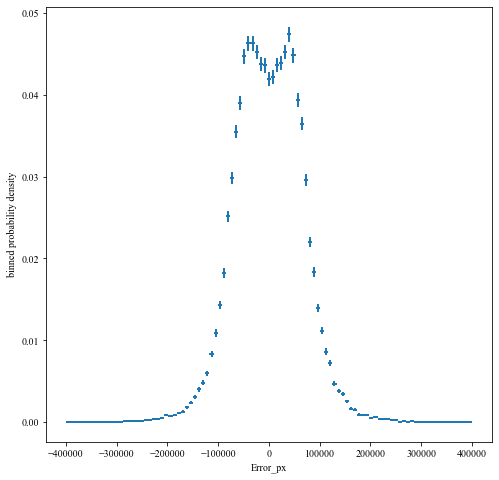

In [46]:
print(np.mean(Error_px))
print(np.std(Error_px))
binneddensity(Error_px, fixedbinning(-400000,400000,100),xlabel = "Error_px")

-269.4413653105355
65600.09907406622


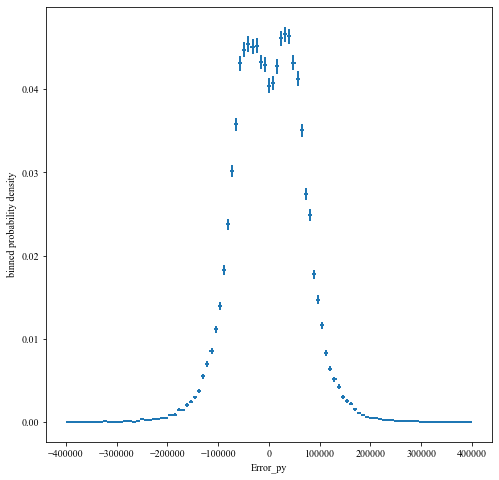

In [47]:
print(np.mean(Error_py))
print(np.std(Error_py))
binneddensity(Error_py, fixedbinning(-400000,400000,100),xlabel = "Error_py")

-1221.0461114404015
197292.11780969644


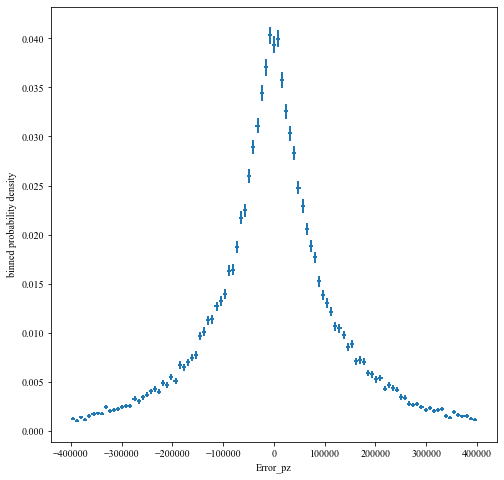

In [48]:
print(np.mean(Error_pz))
print(np.std(Error_pz))
binneddensity(Error_pz, fixedbinning(-400000,400000,100),xlabel = "Error_pz")

17.925620845170855
6009.684088261735


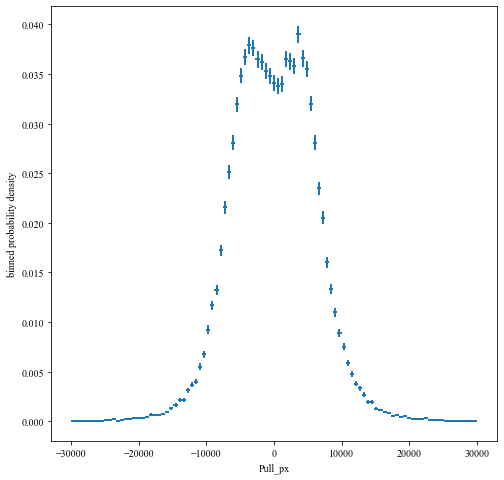

In [52]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-30000,30000,100),xlabel = "Pull_px")

-85.64841367994032
6044.4681135319925


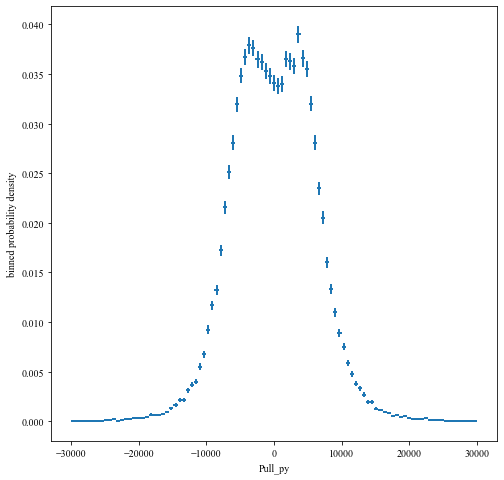

In [56]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_px, fixedbinning(-30000,30000,100),xlabel = "Pull_py")

-316.82180109992646
14761.227176044418


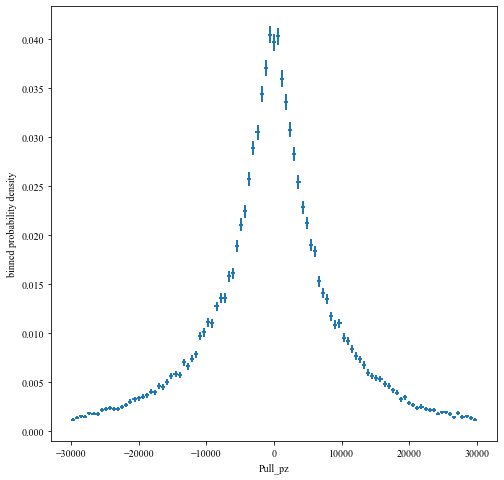

In [58]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-30000,30000,100),xlabel = "Pull_pz")

1.8141624354796987e-05
0.9990188859360498


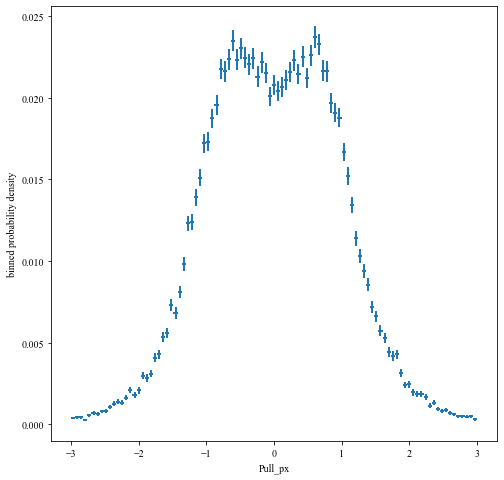

In [62]:
print(np.mean(Pull_bhads_px))
print(np.std(Pull_bhads_px))
binneddensity(Pull_bhads_px, fixedbinning(-3,3,100),xlabel = "Pull_px")

-0.004118477500056556
1.0027136394838427


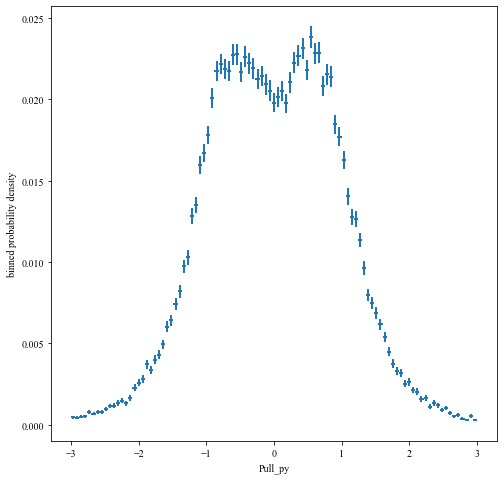

In [63]:
print(np.mean(Pull_bhads_py))
print(np.std(Pull_bhads_py))
binneddensity(Pull_bhads_py, fixedbinning(-3,3,100),xlabel = "Pull_py")

-0.006177098212272144
0.998072699138312


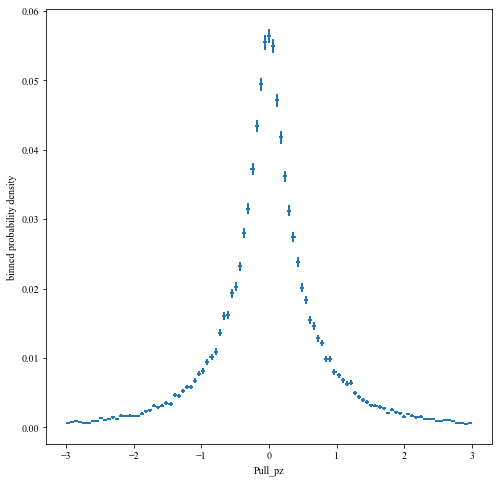

In [64]:
print(np.mean(Pull_bhads_pz))
print(np.std(Pull_bhads_pz))
binneddensity(Pull_bhads_pz, fixedbinning(-3,3,100),xlabel = "Pull_pz")

In [ ]:
#Belows plots the scatter plots of the true bhadron targets vs the neural networks predicted bhadron targets

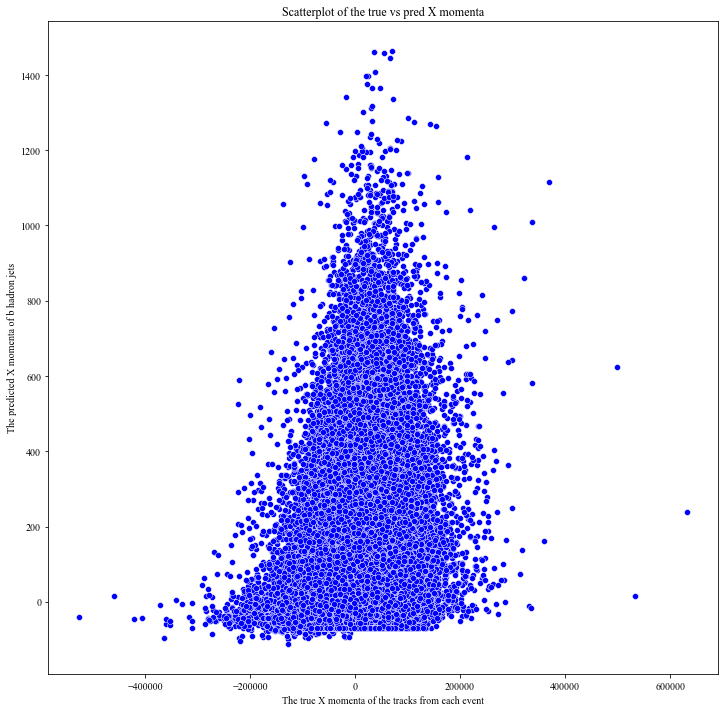

In [42]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions[:,0],
    x = y_train[:,0],
    color = "blue"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.savefig('/home/physics/phujdj/DeepLearningParticlePhysics/Results/ScatterplotPx.png')

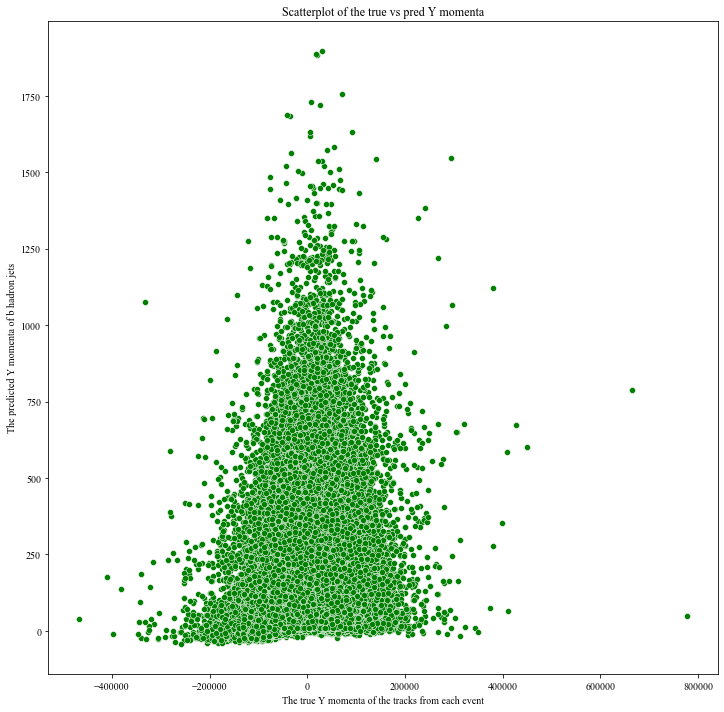

In [43]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions[:,1],
    x = y_train[:,1],
    color = "green"
)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")
plt.savefig('/home/physics/phujdj/DeepLearningParticlePhysics/Results/ScatterplotPy.png')

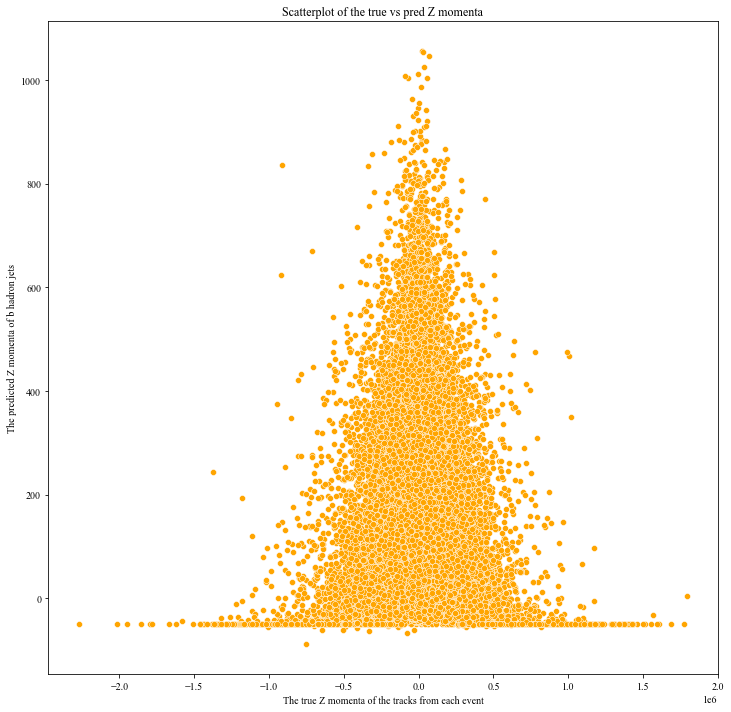

In [44]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions[:,2],
    x = y_train[:,2],
    color = "orange"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")
plt.savefig('/home/physics/phujdj/DeepLearningParticlePhysics/Results/ScatterplotPz.png')

In [ ]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron x momenta

In [67]:
mi_scores_px_momentum =  make_mi_scores(Predictions, y_train[:,0])
print(mi_scores_px_momentum)

5    0.136705
4    0.112468
0    0.076850
2    0.072201
1    0.060396
3    0.056619
Name: MI Scores, dtype: float64


In [68]:
mi_scores_py_momentum =  make_mi_scores(Predictions, y_train[:,1])
print(mi_scores_py_momentum)

3    0.186553
4    0.077311
5    0.071055
1    0.057040
2    0.022354
0    0.020969
Name: MI Scores, dtype: float64


In [69]:
mi_scores_pz_momentum =  make_mi_scores(Predictions, y_train[:,2])
print(mi_scores_px_momentum)

5    0.136705
4    0.112468
0    0.076850
2    0.072201
1    0.060396
3    0.056619
Name: MI Scores, dtype: float64
